In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


llms = [ 
    "gemma3n",  
    "qwen2.5",  
    "llama3.1",  
    "orca2",  
]


examples = {
    "FIC" : "join_examples_dict_1", 
    "CIC" : 'join_examples_dict_2',
    "FSC" : 'vector_based_examples_dict_1',
    "CSC" : 'vector_based_examples_dict_2',
}

model_types = ['TF', 'FT', 'UN', 'IN']


def extract_model_type(model, suffix=""): 
    flag = True
    for ll in llms:
        if ll in model:
            flag = False
    if flag: 
        return "P1"
    elif ' U ' in model: 
        return f"UN{suffix}"
    elif ' ∩ ' in model: 
        return f"IN{suffix}"
    elif '-tf-p2' in model: 
        return "TF"
    elif '-ft-p2' in model: 
        return "FT"
    elif '-z-p2' in model: 
        return "ZS" 
    else: 
        return "P1"
    
def models_from(model):
    for ll in llms:
        if ll in model:
            return ll


In [17]:


def results_extraction_main(): 
    
    groups = dict()
    indexes = list()        
    datasets = ['D2', 'D5', 'D6', 'D7', 'D8']
    for candidate_pairs in ['original', 'standard_blocking']:
        for i in ['recall', 'precision', 'f1', 'time (sec)']:
            
            key = (candidate_pairs, i) if i!='time (sec)' else (candidate_pairs, 'runtime')
            groups[key] = list()
            for dataset in datasets:
            
                results = f'../results/{candidate_pairs}/{dataset}_clustering.csv'
                results = pd.read_csv(results)

                results['model_type'] = results['model'].apply(lambda x: extract_model_type(x, ''))
                results['_from'] = results['model'].apply(models_from)
                
                if candidate_pairs == 'original': 
                    results = results[(results['model_type'] == 'UN') & (results['examples'] == examples['FSC'])] 
                else: 
                    results = f'../results/{candidate_pairs}/{dataset}_ui.csv'
                    results = pd.read_csv(results)
                    cols = ["precision","recall","f1"]

                    for col in cols: 
                        results[col] = results[col] * 100

                    results['model_type'] = results['model'].apply(lambda x: extract_model_type(x, ""))
                    results['_from'] = results['model'].apply(models_from)
                    results = results[(results['model_type'] == 'UN') & (results['examples'] == examples['FSC'])] 
                


                groupby = results.groupby(by=['_from'])
            
                for ll in llms: 
                    if f'{dataset}-{ll}' not in indexes:
                        indexes.append(f'{dataset}-{ll}')
                    if i == 'time (sec)' : 
                        average_runtime = groupby.get_group(ll)[i].mean()
                        mm = int(average_runtime // 60)
                        ss = int(average_runtime % 60)
                        average_runtime_mm_ss = f"{mm:02d}:{ss:02d}"
                        groups[(candidate_pairs,'runtime')].append(average_runtime_mm_ss)
                    else:
                        groups[key].append(groupby.get_group(ll)[i].mean())
    
    return groups, indexes


def results_extraction_ComEM(): 
    
    groups = dict()
    indexes = list()        
    datasets = ['D2', 'D5', 'D6', 'D7', 'D8']
    for candidate_pairs in ['Com-EM']:
        for i in ['recall', 'precision', 'f1-score', 'execution_time']:
            if i == 'f1-score':
                key = (candidate_pairs, 'f1')
            elif i == 'execution_time': 
                key = (candidate_pairs, 'runtime')
            else:
                key = (candidate_pairs, i)
            groups[key] = list()
            
            results = f'../results/com_em.csv'
            results = pd.read_csv(results)
            groupby = results.groupby(by=['dataset', 'model'])

            for dataset in datasets:
                for ll in llms: 
                    if f'{dataset}-{ll}' not in indexes:
                        indexes.append(f'{dataset}-{ll}')
                    if i == 'execution_time' : 
                        average_runtime = groupby.get_group((dataset, ll))[i].mean()
                        mm = int(average_runtime // 60)
                        ss = int(average_runtime % 60)
                        average_runtime_mm_ss = f"{mm:02d}:{ss:02d}"
                        groups[(candidate_pairs,'runtime')].append(average_runtime_mm_ss)
                    else:
                        groups[key].append(groupby.get_group((dataset, ll))[i].mean())
    
    
    return groups, indexes


In [ ]:

groups, indexes = results_extraction_main()
pyjedai_df = pd.DataFrame(groups, index=indexes)

pyjedai_df.to_excel("FSC_UN_metrics.xlsx", engine='openpyxl')
pyjedai_df

original                               standard_blocking  \
                recall  precision         f1 runtime            recall   
D2-gemma3n   82.330827  94.150035  87.843891   38:05         90.509761   
D2-qwen2.5   78.477444  97.722765  87.048187   17:52         87.635575   
D2-llama3.1  78.806391  87.127743  82.757742   18:02         87.689805   
D2-orca2     76.080827  89.702441  82.331715   15:30         86.388286   
D5-gemma3n   92.188295  83.958437  87.879828   45:44         95.244640   
D5-qwen2.5   90.508906  84.528102  87.416246   17:56         93.870258   
D5-llama3.1  91.603053  77.330621  83.862948   18:18         93.347993   
D5-orca2     62.849873  81.674227  71.031710   13:10         70.560748   
D6-gemma3n   86.490683  68.479982  76.438110   40:46         90.401786   
D6-qwen2.5   72.981366  69.151754  71.014964   16:00         72.433036   
D6-llama3.1  80.020704  54.860887  65.086129   16:27         77.566964   
D6-orca2     76.656315  60.167498  67.417036   11:48         63.950893   
D7-gemma3n   90.869565  54.650844  68.250089   46:37         87.704918   
D7-qwen2.5   94.009662  53.623095  68.291534   18:20         94.057377   
D7-llama3.1  93.719807  43.783881  59.682319   19:05         87.448770   
D7-orca2     88.888889  52.672197  66.142874   14:18         85.706967   
D8-gemma3n   77.960141  39.653137  52.542461   55:33         86.613119   
D8-qwen2.5   69.812427  62.515810  65.936124   22:51         79.183400   
D8-llama3.1  74.208675  34.216578  46.811932   23:16         84.069612   
D8-orca2     49.355217  37.269006  42.418043   17:01         54.752343   

                                           
             precision         f1 runtime  
D2-gemma3n   90.328898  90.418816   17:25  
D2-qwen2.5   96.481293  91.845542   07:28  
D2-llama3.1  82.408619  84.957603   07:38  
D2-orca2     90.171275  88.232037   06:19  
D5-gemma3n   82.425695  88.348387   38:31  
D5-qwen2.5   84.292413  88.814819   15:20  
D5-llama3.1  72.477758  81.468793   15:41  
D5-orca2     79.056699  74.506787   11:51  
D6-gemma3n   66.991496  76.914027   37:31  
D6-qwen2.5   66.447023  69.301030   14:37  
D6-llama3.1  45.769000  57.126556   15:00  
D6-orca2     61.085825  62.341614   10:53  
D7-gemma3n   48.977170  62.842586   64:01  
D7-qwen2.5   52.359561  67.266874   23:14  
D7-llama3.1  38.897967  53.690181   24:03  
D7-orca2     49.025412  62.327736   19:30  
D8-gemma3n   42.740486  57.231915   48:06  
D8-qwen2.5   66.351390  72.201231   19:54  
D8-llama3.1  33.123280  47.480176   20:16  
D8-orca2     38.536156  45.206662   15:00

In [ ]:
groups, indexes = results_extraction_ComEM()
com_em = pd.DataFrame(groups, index=indexes)
com_em.to_excel("Com_EM_metrics.xlsx", engine='openpyxl')
com_em

Com-EM                              
                recall  precision         f1 runtime
D2-gemma3n   79.353680  25.802685  38.942731   49:06
D2-qwen2.5   35.727110  33.166667  34.399309   29:45
D2-llama3.1  92.998205   6.648697  12.410158   38:31
D2-orca2      0.000000   0.000000   0.000000   68:43
D5-gemma3n   90.690691   5.462109  10.303651  235:38
D5-qwen2.5   52.252252  13.975904  22.053232  141:40
D5-llama3.1  87.987988   0.891417   1.764954  153:06
D5-orca2      6.606607  10.328638   8.058608  381:42
D6-gemma3n   44.444444   0.143678   0.286430  213:38
D6-qwen2.5   55.555556   0.455373   0.903342  123:00
D6-llama3.1  66.666667   0.027073   0.054125  141:50
D6-orca2      0.000000   0.000000   0.000000  389:56
D7-gemma3n   50.000000   0.023810   0.047596  214:06
D7-qwen2.5    0.000000   0.000000   0.000000  132:17
D7-llama3.1  83.333333   0.013230   0.026456  148:47
D7-orca2      0.000000   0.000000   0.000000  362:45
D8-gemma3n   83.225806   3.086494   5.952244  119:40
D8-qwen2.5   38.709677  15.894040  22.535211   72:03
D8-llama3.1  93.548387   0.835398   1.656007   77:18
D8-orca2      0.000000   0.000000   0.000000  195:47

In [74]:
import matplotlib.pyplot as plt
import numpy as np
def grouped_bar_chart(df, dataset):
    # Extract labels and metrics
    models = df["model_name"].values
    metrics = ["recall", "precision", "f1"]

    # Bar positions
    x = np.arange(len(models))  # positions for models
    width = 0.2                # width of each bar

    # Create plot
    fig, ax = plt.subplots(figsize=(6, 5))

    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, df[metric], width, label=metric)

    # Formatting
    ax.set_xticks(x + width)  # center the ticks
    ax.set_xticklabels(models)
    ax.set_ylabel("Score")
    ax.set_title(f"Model Performance on {dataset}: Recall / Precision / F1")
    ax.legend()

    plt.show()
    
def df_plot_show_runtime(df, dataset): 
    models = list(df['model_name'].values)
    average_runtime_to_mmss : list[str] = list(df['runtime'].values)
    
    average_runtime : list[int] = []
    for mmss  in average_runtime_to_mmss:
        mm, ss = mmss.split(":")
        mm = int(mm) * 60
        ss = int(ss)
        average_runtime.append(mm+ss)
        
        
    df = pd.DataFrame({"Models Types" : models, "Average Runtime (mm:ss)" : average_runtime_to_mmss})


    # Create the bar plot
    plt.figure(figsize=(6, 5))
    bars = plt.bar(models, average_runtime, alpha=0.8, edgecolor='navy', width=0.2, linewidth=1.2)

    # Customize the plot
    
    # Step 4: Format y-axis ticks back to mm:ss
    def format_mmss(x, pos):
        mm = int(x // 60)
        ss = int(x % 60)
        return f"{mm:02d}:{ss:02d}"

    from matplotlib.ticker import FuncFormatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_mmss))    
    
    plt.title(f'Model Runtime on {dataset}', fontsize=16, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Average Runtime (mm:ss)', fontsize=12)
    # plt.xticks(ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        mm = int(height // 60)
        ss = int(height % 60)
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f"{mm:02d}:{ss:02d}", ha='center', va='bottom', fontweight='bold')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()


# KNN-Join

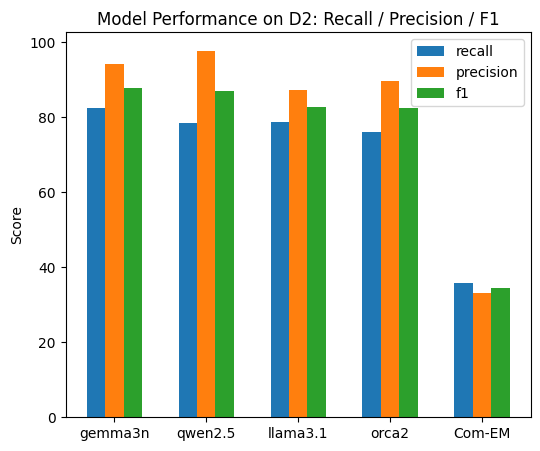

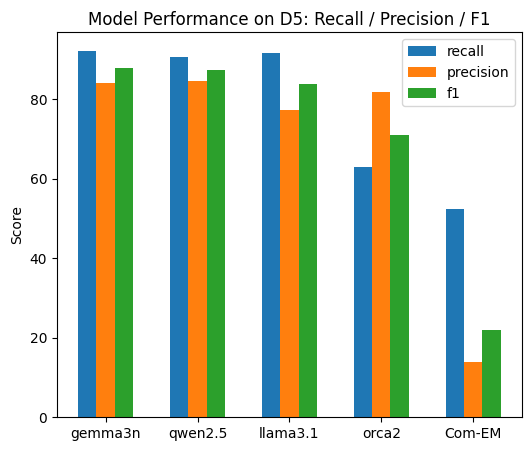

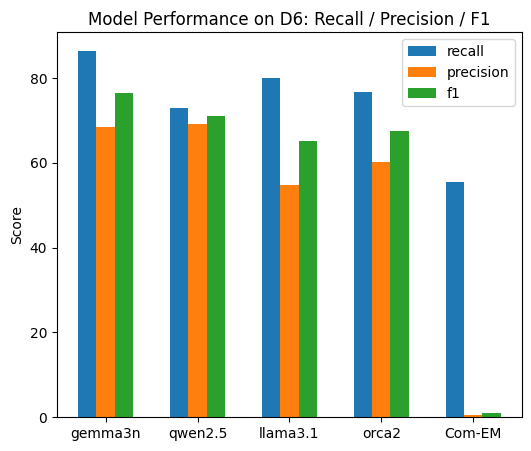

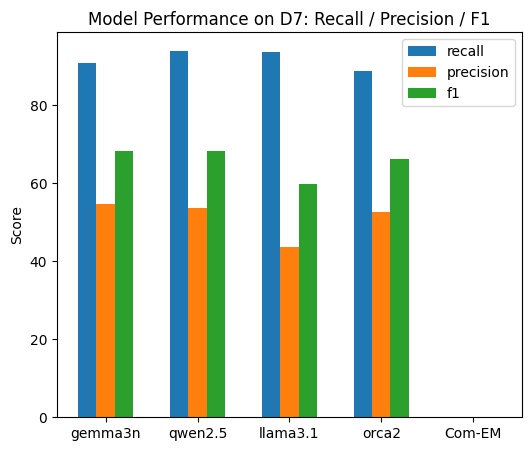

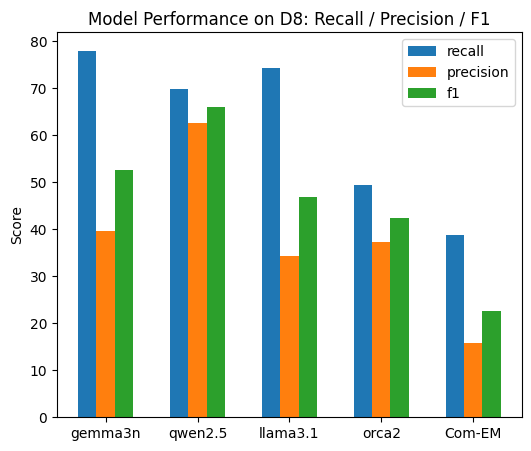

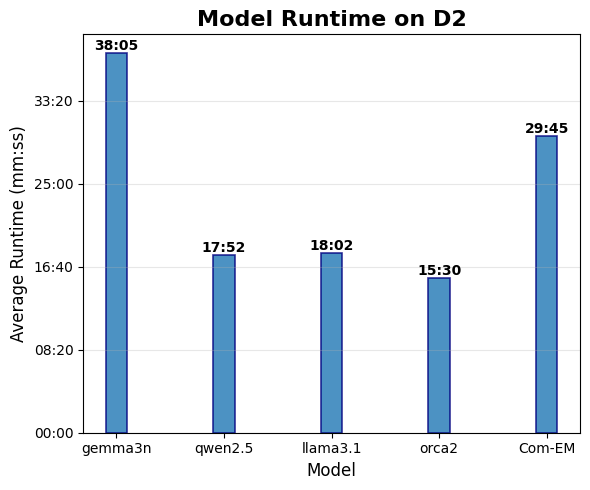

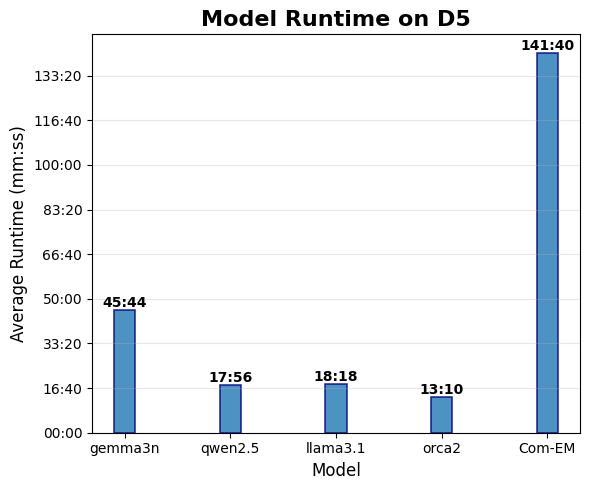

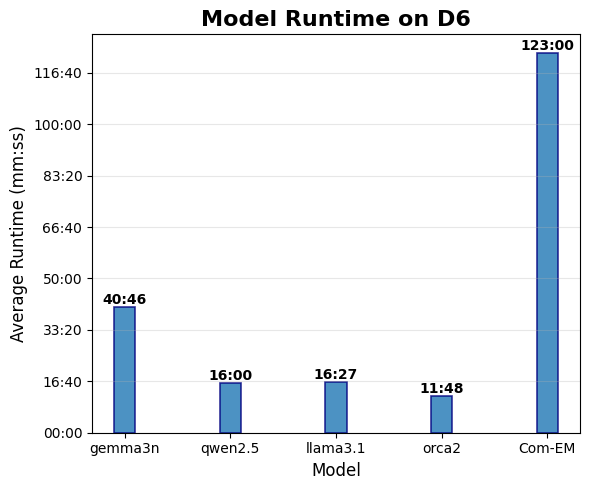

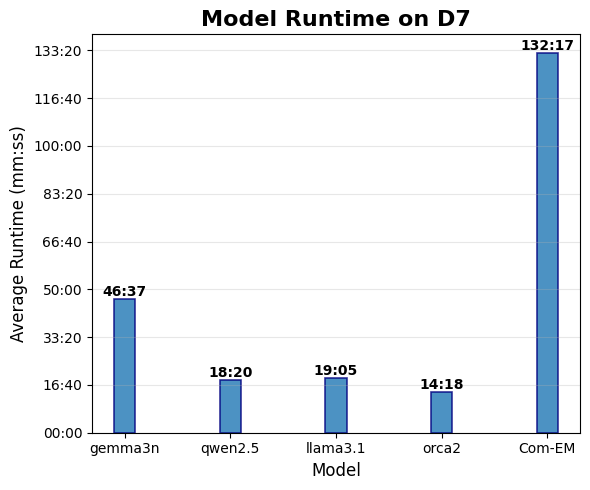

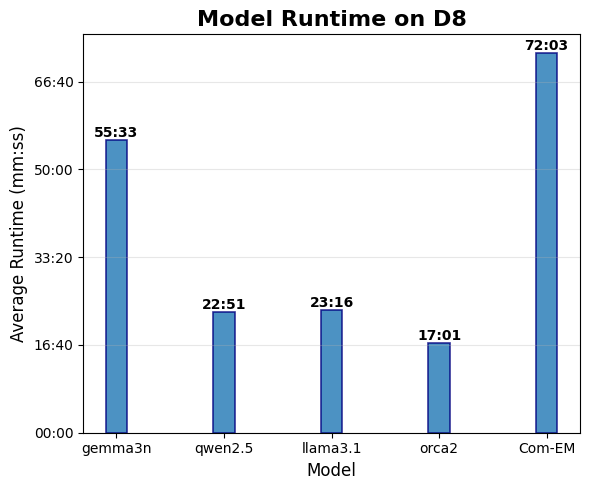

In [ ]:
knn = pyjedai_df['original']
com_em_qwen = com_em['Com-EM']


knn = knn.reset_index()
com_em_qwen = com_em_qwen.reset_index()

# Step 2: Split the index string into two new columns
knn[['dataset', 'model_name']] = knn['index'].str.split('-', n=1, expand=True)
com_em_qwen[['dataset', 'model_name']] = com_em_qwen['index'].str.split('-', n=1, expand=True)

knn = knn.drop(columns=['index'])
com_em_qwen = com_em_qwen.drop(columns=['index'])
com_em_qwen = com_em_qwen[com_em_qwen['model_name'] == 'qwen2.5']
com_em_qwen['model_name'] = 'Com-EM'
knn = pd.concat([knn, com_em_qwen])

for dataset in ['D2', 'D5', 'D6', 'D7', 'D8']:
    grouped_bar_chart(knn[knn['dataset'] == dataset], dataset)
    
for dataset in ['D2', 'D5', 'D6', 'D7', 'D8']:
    df_plot_show_runtime(knn[knn['dataset'] == dataset], dataset)
    

# Standard Blocking

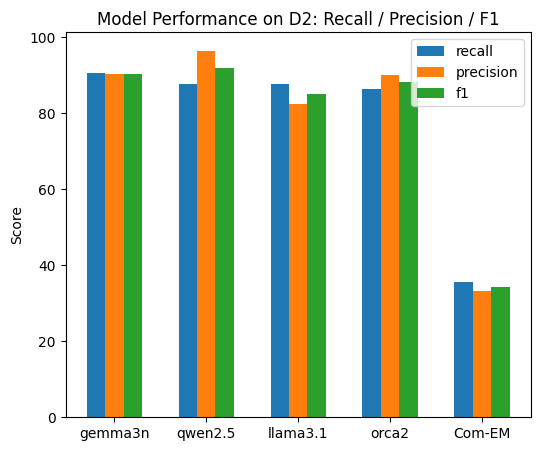

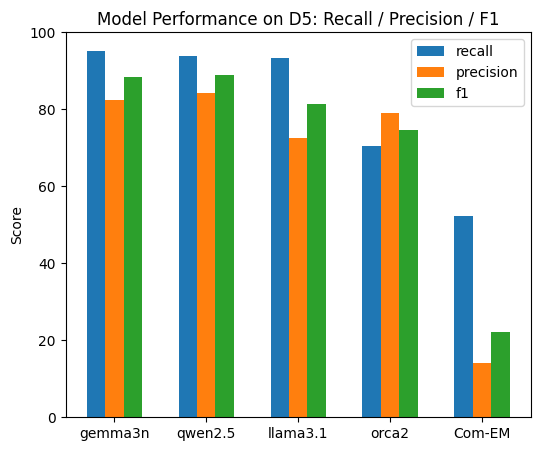

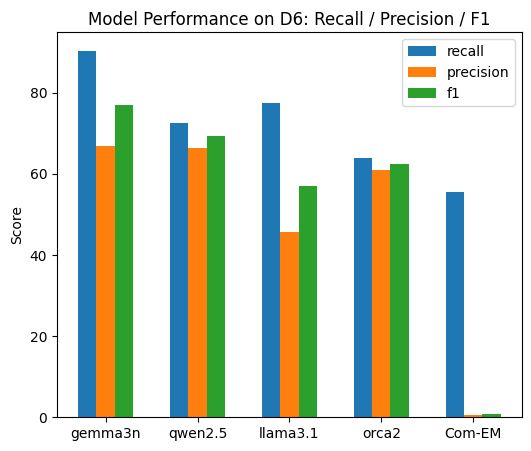

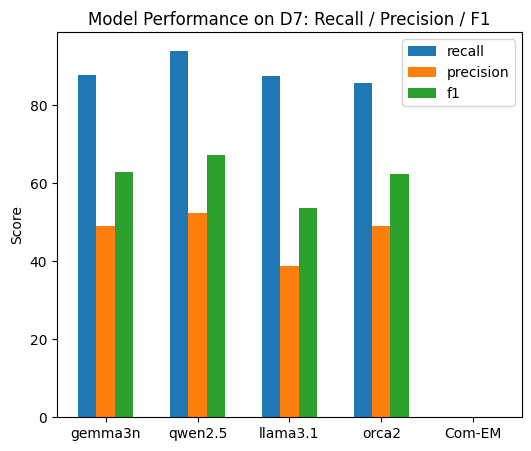

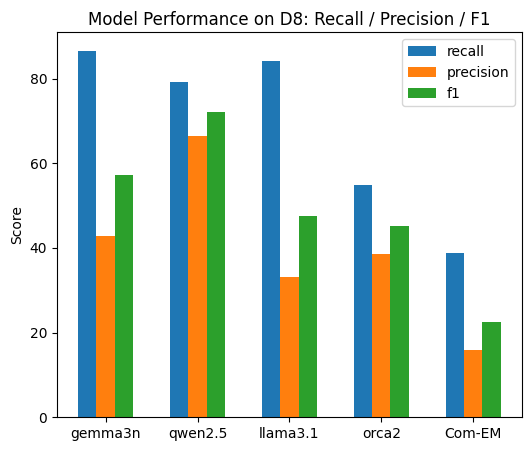

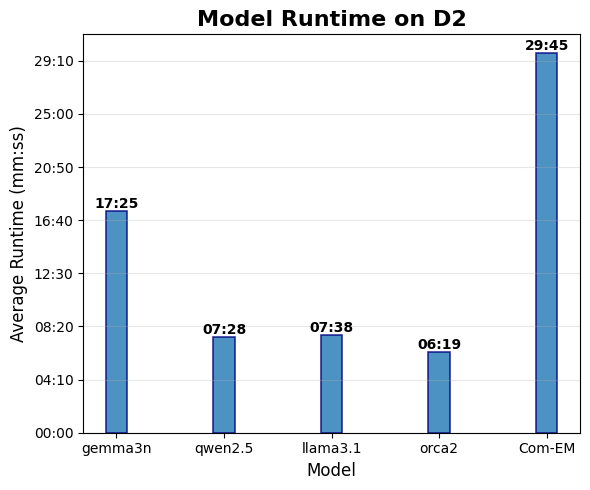

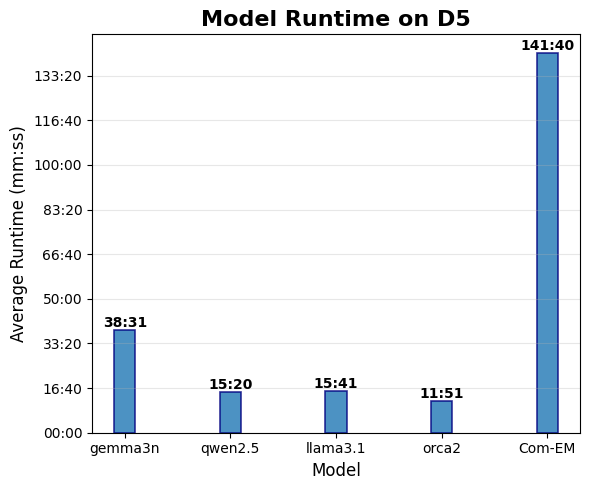

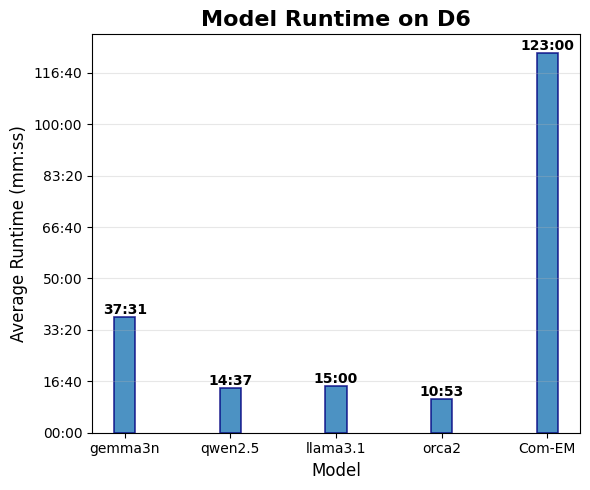

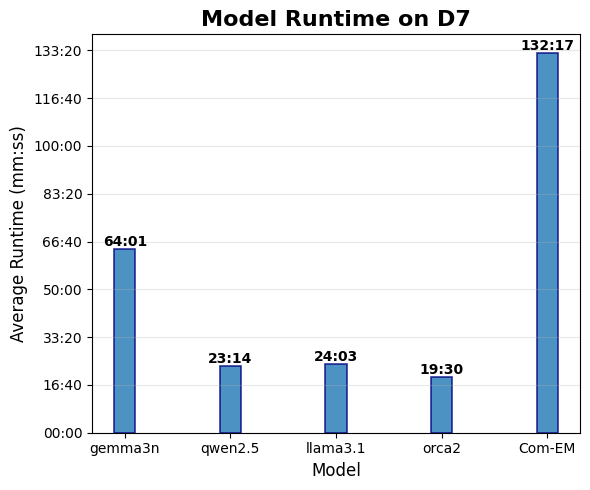

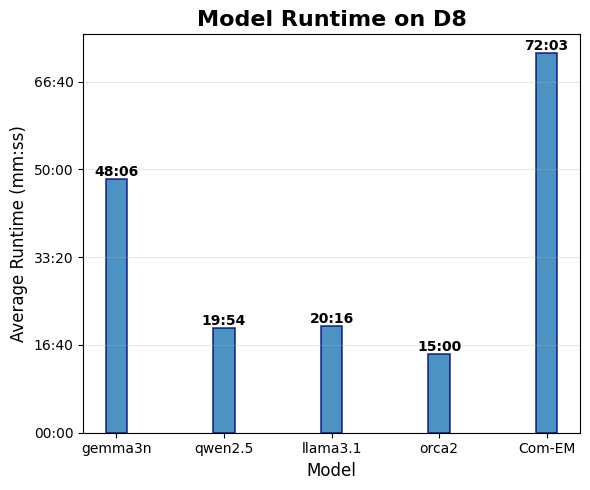

In [76]:
sb = pyjedai_df['standard_blocking']
com_em_qwen = com_em['Com-EM']


sb = sb.reset_index()
com_em_qwen = com_em_qwen.reset_index()

# Step 2: Split the index string into two new columns
sb[['dataset', 'model_name']] = sb['index'].str.split('-', n=1, expand=True)
com_em_qwen[['dataset', 'model_name']] = com_em_qwen['index'].str.split('-', n=1, expand=True)

sb = sb.drop(columns=['index'])
com_em_qwen = com_em_qwen.drop(columns=['index'])
com_em_qwen = com_em_qwen[com_em_qwen['model_name'] == 'qwen2.5']
com_em_qwen['model_name'] = 'Com-EM'
sb = pd.concat([sb, com_em_qwen])

sb

for dataset in ['D2', 'D5', 'D6', 'D7', 'D8']:
    grouped_bar_chart(sb[sb['dataset'] == dataset], dataset)
    
for dataset in ['D2', 'D5', 'D6', 'D7', 'D8']:
    df_plot_show_runtime(sb[sb['dataset'] == dataset], dataset)


# Average pyJedAI

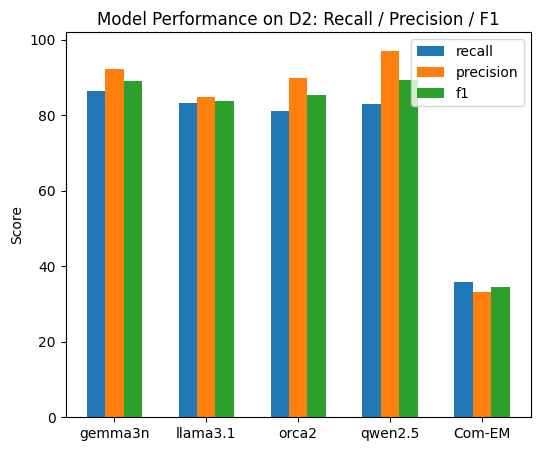

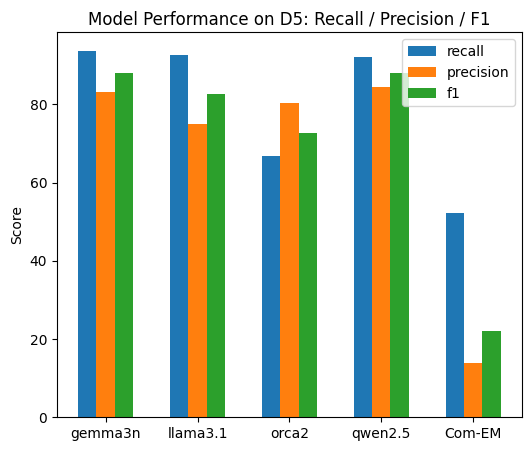

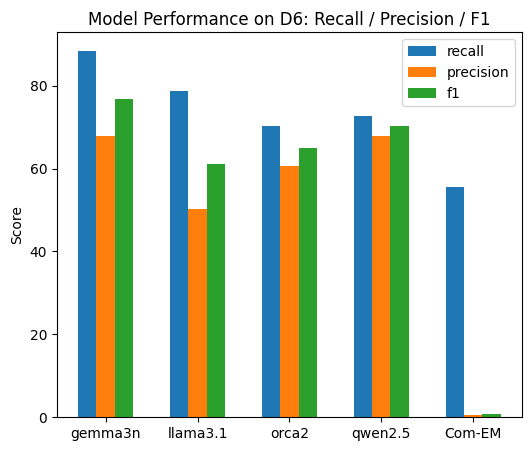

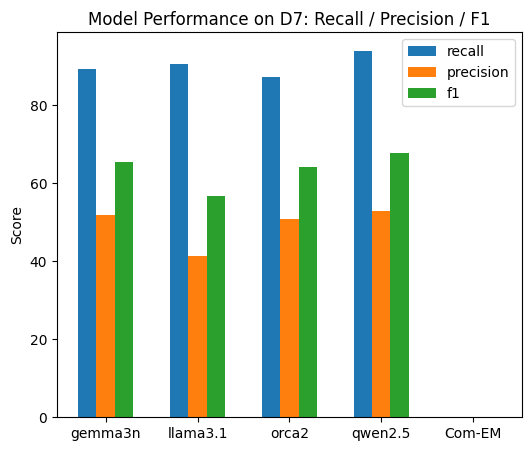

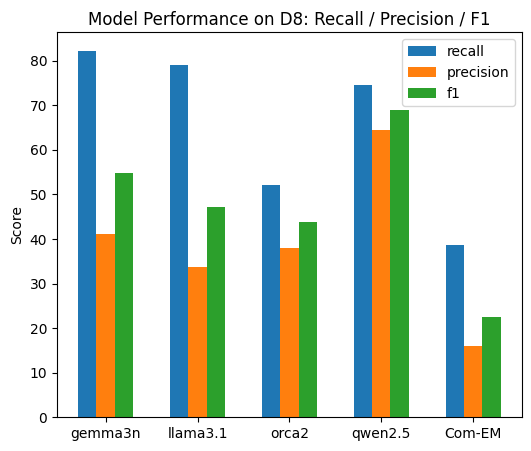

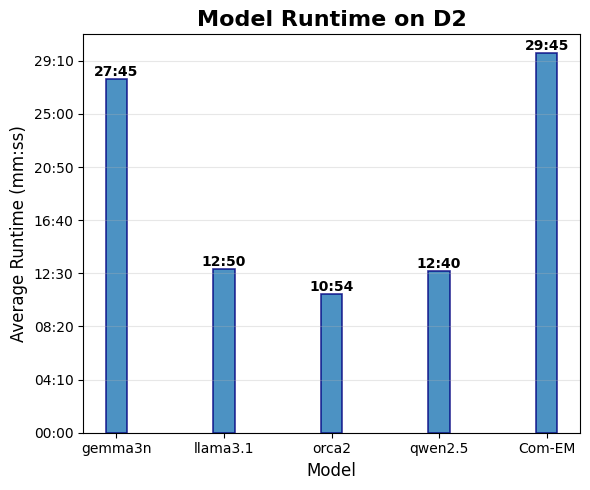

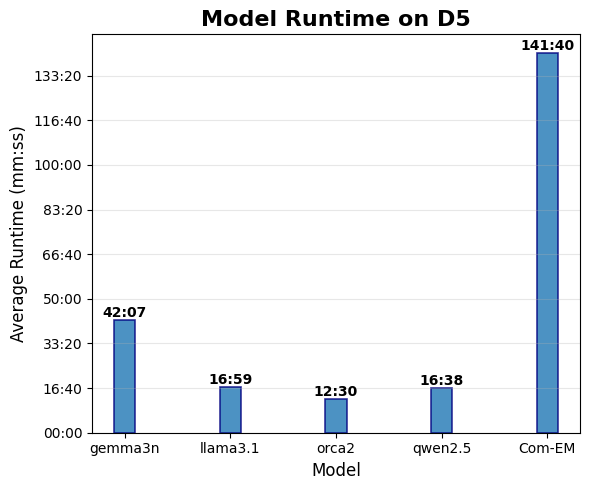

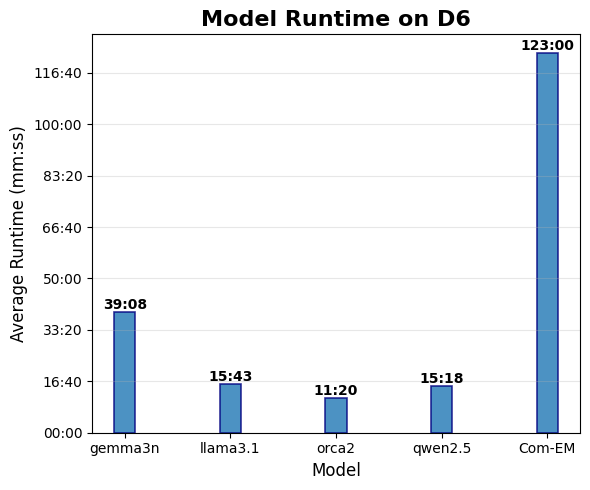

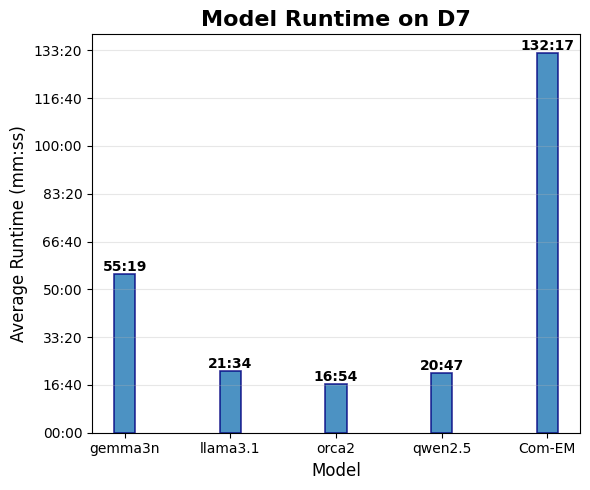

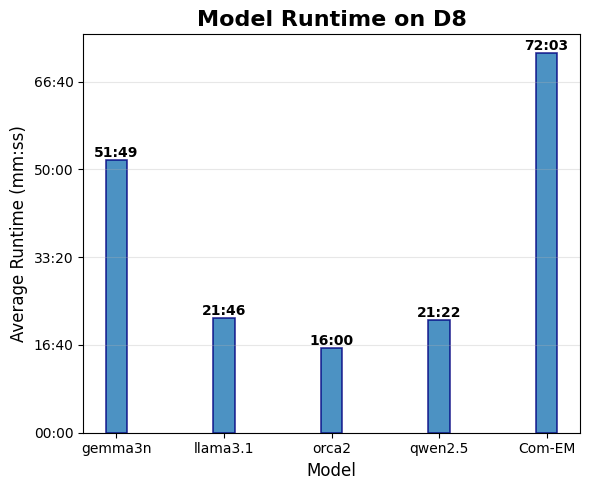

In [83]:
sb = sb[sb['model_name'] != 'Com-EM']
knn = knn[knn['model_name'] != 'Com-EM']

average = pd.concat([sb, knn])

def runtime_to_sec(runtime: str): 
    mm, ss =runtime.split(":")
    mm = int(mm) * 60
    return mm + int(ss)    

def sec_to_runtime(runtime: int): 
    mm = int(runtime // 60)
    ss = int(runtime % 60)
    return f"{mm:02d}:{ss:02d}"
     

average['runtime'] = average['runtime'].apply(runtime_to_sec)
average = (
    average.groupby(['dataset', 'model_name'], as_index=False).mean(numeric_only=True)
)
average['runtime'] = average['runtime'].apply(sec_to_runtime)
average = pd.concat([average, com_em_qwen])

for dataset in ['D2', 'D5', 'D6', 'D7', 'D8']:
    grouped_bar_chart(average[average['dataset'] == dataset], dataset)
    
for dataset in ['D2', 'D5', 'D6', 'D7', 'D8']:
    df_plot_show_runtime(average[average['dataset'] == dataset], dataset)